In [12]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from optuna.trial import Trial
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

from typing import List, Tuple

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [3]:
def objective(
    trial: Trial,
    X: np.ndarray,
    y: np.ndarray,
    folds: np.ndarray,
    unique_folds: np.ndarray
    ) -> float:
    """
    Optuna objective function for ElasticNet hyperparameter tuning.
    
    Args:
        trial: Optuna trial object
        X: Feature matrix
        y: Target variable array
        folds: Fold assignment array
        unique_folds: Array of unique fold identifiers
    
    Returns:
        Mean RMSE across all folds
    """
    # Suggest hyperparameters
    alpha = trial.suggest_float('alpha', 1e-5, 10.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    # Store fold metrics for this trial
    fold_scores = []
    
    # Cross-validation loop
    for fold in unique_folds:
        # Split data
        train_idx = folds != fold
        val_idx = folds == fold
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train ElasticNet
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10000,
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        # Predict on validation set
        val_predictions = model.predict(X_val)
        
        # Calculate fold RMSE
        fold_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        fold_scores.append(fold_rmse)
    
    # Return mean RMSE across folds
    mean_rmse = np.mean(fold_scores)
    
    return mean_rmse


In [4]:
def train_and_evaluate_cv(
    X: np.ndarray,
    y: np.ndarray,
    folds: np.ndarray,
    unique_folds: np.ndarray,
    alpha: float,
    l1_ratio: float
    ) -> Tuple[np.ndarray, List[float], List[float], List[float]]:
    """
    Optuna objective function for ElasticNet hyperparameter tuning
    
    Parameters:
    -----------
    trial : Trial
        Optuna trial object
    X : np.ndarray
        Feature matrix
    y : np.ndarray
        Target variable array
    folds : np.ndarray
        Fold assignment array
    unique_folds : np.ndarray
        Array of unique fold identifiers
    
    Returns:
    --------
    float
        Mean RMSE across all folds
    """
    # Initialize arrays to store OOF predictions and fold metrics
    oof_predictions = np.zeros(len(y), dtype=np.float64)
    fold_rmse_list = []
    fold_mae_list = []
    fold_r2_list = []
    
    # Cross-validation loop with best parameters
    for fold in unique_folds:
        print(f"\nTraining fold {fold}...")
        
        # Split data
        train_idx = folds != fold
        val_idx = folds == fold
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        print(f"  Train samples: {len(y_train)}, Val samples: {len(y_val)}")
        
        # Train ElasticNet with best parameters
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10000,
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        # Predict on validation set
        val_predictions = model.predict(X_val)
        oof_predictions[val_idx] = val_predictions
        
        # Calculate fold metrics
        fold_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        fold_mae = mean_absolute_error(y_val, val_predictions)
        fold_r2 = r2_score(y_val, val_predictions)
        
        fold_rmse_list.append(fold_rmse)
        fold_mae_list.append(fold_mae)
        fold_r2_list.append(fold_r2)
        
        print(f"  Fold {fold} - RMSE: {fold_rmse:.4f}, MAE: {fold_mae:.4f}, R²: {fold_r2:.4f}")
    
    return oof_predictions, fold_rmse_list, fold_mae_list, fold_r2_list


In [5]:
def train_final_model(
    X: np.ndarray,
    y: np.ndarray,
    alpha: float,
    l1_ratio: float
    ) -> ElasticNet:
    """
    Train final ElasticNet model on all data
    
    Parameters:
    -----------
    X : np.ndarray
        Feature matrix
    y : np.ndarray
        Target variable array
    alpha : float
        ElasticNet alpha parameter
    l1_ratio : float
        ElasticNet l1_ratio parameter
    """
    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=10000,
        random_state=42
    )
    
    model.fit(X, y)
    
    return model
    

In [44]:
def create_regression_plot(
    y: np.ndarray,
    oof_predictions: np.ndarray,
    oof_r2: float,
    oof_rmse: float,
    oof_mae: float,
    output_path: str
    ) -> None:
    """
    Create and save a 1:1 regression plot comparing actual vs predicted values
    
    Parameters:
    -----------
    y : np.ndarray
        Array of actual/true values (ground truth) from the dataset
    oof_predictions : np.ndarray
        Array of out-of-fold predicted values from the model
    oof_r2 : float
        Overall R² (coefficient of determination) score for the predictions
    oof_rmse : float
        Overall Root Mean Squared Error in the same units as y
    oof_mae : float
        Overall Mean Absolute Error in the same units as y
    output_path : str
        File path where the plot will be saved (e.g., 'plot.png')
    """
    # Ensure arrays are numeric
    y = np.asarray(y, dtype=np.float64)
    oof_predictions = np.asarray(oof_predictions, dtype=np.float64)
    
    plt.figure(figsize=(8, 8))
    
    # Add invisible lines for R² and RMSE at top of legend
    plt.plot([], [], ' ', label=f'R² = {oof_r2:.2f}')
    plt.plot([], [], ' ', label=f'RMSE = {oof_rmse:.2f} m')
    
    # Scatter plot with light green fill
    plt.scatter(y, oof_predictions, alpha=0.6, s=20, c='lightgreen', edgecolors='k', linewidth=0.5)
    
    # Add 1:1 line
    min_val = float(min(y.min(), oof_predictions.min()))
    max_val = float(max(y.max(), oof_predictions.max()))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')
    
    # Add best fit line with professional equation formatting (black)
    z = np.polyfit(y, oof_predictions, 1)
    p = np.poly1d(z)
    
    # Format equation with proper sign handling
    slope = z[0]
    intercept = z[1]
    sign = '+' if intercept >= 0 else '-'
    eq_label = f'Best Fit: y = {slope:.2f}x {sign} {abs(intercept):.2f}'
    
    plt.plot(y, p(y), "k-", linewidth=2, alpha=0.8, label=eq_label)
    
    # Labels and title with larger fonts
    plt.xlabel('LiDAR Height (m)', fontsize=18, fontweight='bold')
    plt.ylabel('Predicted Height (m)', fontsize=18, fontweight='bold')
    plt.title('ElasticNet Out-of-Fold Predictions', 
              fontsize=20, fontweight='bold')
    
    # Increase tick label size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend with larger font
    plt.legend(loc='upper left', fontsize=14)
    
    # Equal aspect ratio
    plt.axis('equal')
    plt.tight_layout()
    
    # Save plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to: {output_path}")
    
    plt.show()
    

In [48]:
def print_model_coefficients(
    model: ElasticNet,
    wrap_every: int = 8
    ) -> None:
    """
    Print model coefficients as GEE JavaScript array code
    
    Parameters:
    -----------
    model : ElasticNet
        Trained ElasticNet model
    wrap_every : int
        Number of coefficients to print per line (default: 8)
    """
    coefficients = model.coef_
    
    print("var coefficients = ee.Array([")
    
    for i in range(0, len(coefficients), wrap_every):
        chunk_end = min(i + wrap_every, len(coefficients))
        coef_strings = [f"{coefficients[j]:.5f}" for j in range(i, chunk_end)]
        line = "  " + ", ".join(coef_strings)
        
        # Add comma if not the last line
        if chunk_end < len(coefficients):
            line += ","
        
        print(line)
    
    print("]);\n")
    print(f"var intercept = {model.intercept_:.5f};")
    
    return None
    

In [14]:
def assign_folds(
    df: pd.DataFrame, 
    n_splits: int = 5, 
    random_state: int = 3702 
    ):
    """
    Assign randomized folds to a dataframe for cross-validation
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataset to assign folds to
    n_splits : int
        Number of folds (default: 5)
    random_state : int
        Random seed for reproducibility (default: 42)
    
    Returns:
    --------
    pandas DataFrame with a new 'fold' column
    """
    # Create a copy to avoid modifying the original
    df_with_folds = df.copy()
    
    # Initialize KFold with shuffling
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Create an array to store fold assignments
    fold_assignments = np.zeros(len(df), dtype=int)
    
    # Assign fold numbers
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df)):
        fold_assignments[val_idx] = fold_idx
    
    # Add fold column to dataframe
    df_with_folds['fold_id'] = fold_assignments
    
    return df_with_folds
    

## Overview

In this script, we use the SciKit-Learn library to fit an ElasticNet regression model. ElasticNet is a regularized regression model that includes both the L1 and L2 norms in the regularization term. These regularization terms combat overfitting by encouraging the model to select a solution that maximizes predictive performance AND constrains the size of the values of the coefficients (i.e., their magnitudes).  

The nice thing about linear models... well, there are many nice things about linear models. However, a very nice property of linear models when using Google Earth Engine and the AlphaEarth Foundations is that the models are super simple. They consist of the coefficients (a list of numbers) and an intercept term (a single number). As we will demonstrate below, this means you can fit a model locally with SciKit-Learn or the excellent glmnet package for the R software language and then just literally copy-and-paste the model into GEE. Additionally, given model application basically boils down to some matrix multiplication, inference is very cost efficient for commercial users.  

The approach outlined here can be extended to fit a generalized linear model (e.g., a binomial for classification tasks). In these cases, you would fit the model locally and then upload the coefficients and then apply the necessary transformation to the model prediction (e.g., a logit transform) to obtain probabilitites.  

In this script we do the following:
- Load in the dataset
- Split the randomized folds for model development
- Perform a hyperparameter search using Bayesian Optimization techniques
- Plot the out-of-fold predictions of the final model as a one-to-one plot
- Print the coefficients for use in Google Earth Engine

## File I/O

In [27]:
# Define the project folder path 
project_folder = "C:/Users/johnb/Desktop/GEE_MediumBlog_Logic"

In [28]:
# Load the modeling dataset
modeling_df = gpd.read_file(os.path.join(project_folder, "data", "forest_ht_dataset.csv"))

In [29]:
# Define where the figure will be saved
output_path = os.path.join(project_folder, "figures", "elasticnet_oof_plot.png")

## Format the modeling dataset

Here, apply randomly assign each sample to a one of 5 cross validation folds. We also specify the dependent variable, the forest height (m), and indpendent (i.e., features), the embedding field values, that will be used to develop the forest height regression model.

In [16]:
modeling_df = assign_folds(modeling_df, n_splits=5)

In [17]:
# Define the key dataset properties
dependent_var = "height_m"
independent_var = [
    'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 
    'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 
    'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 
    'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 
    'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 
    'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 
    'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 
    'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63'
]

In [19]:
# Get the response vector and the design matrix
X = modeling_df[independent_var].values
y = modeling_df[dependent_var].values.astype(np.float64)
folds = modeling_df["fold_id"].values
unique_folds = np.unique(folds)


## Run the hyperparameter optimization 

Here, we use spatial cross-validation to tun the ElasticNet hyperparameters. 

In [21]:
study = optuna.create_study(direction='minimize', study_name='elasticnet_tuning')
study.optimize(
    lambda trial: objective(trial, X, y, folds, unique_folds),
    n_trials = 100,
    show_progress_bar = True
)


Best trial: 95. Best value: 3.38582: 100%|███████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


In [23]:
print("\n" + "="*60)
print("Optimization completed!")
print(f"\nBest trial value (RMSE): {study.best_trial.value:.4f}")
print(f"Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value:.6f}")
    


Optimization completed!

Best trial value (RMSE): 3.3858
Best hyperparameters:
  alpha: 0.000128
  l1_ratio: 0.583981


In [24]:
# Train final model with best hyperparameters and evaluate with cross-validation
print("\nTraining final model with best hyperparameters...")
print("="*60)

best_alpha = study.best_params['alpha']
best_l1_ratio = study.best_params['l1_ratio']

# Train and evaluate
oof_predictions, fold_rmse_list, fold_mae_list, fold_r2_list = train_and_evaluate_cv(
    X, y, folds, unique_folds, best_alpha, best_l1_ratio
)



Training final model with best hyperparameters...

Training fold 0...
  Train samples: 4000, Val samples: 1000
  Fold 0 - RMSE: 3.2999, MAE: 2.5603, R²: 0.6473

Training fold 1...
  Train samples: 4000, Val samples: 1000
  Fold 1 - RMSE: 3.5533, MAE: 2.7153, R²: 0.6213

Training fold 2...
  Train samples: 4000, Val samples: 1000
  Fold 2 - RMSE: 3.4280, MAE: 2.6698, R²: 0.6068

Training fold 3...
  Train samples: 4000, Val samples: 1000
  Fold 3 - RMSE: 3.2739, MAE: 2.5209, R²: 0.6187

Training fold 4...
  Train samples: 4000, Val samples: 1000
  Fold 4 - RMSE: 3.3740, MAE: 2.6340, R²: 0.6183


In [31]:
# Calculate overall OOF metrics
oof_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
oof_mae = mean_absolute_error(y, oof_predictions)
oof_r2 = r2_score(y, oof_predictions)

print("\nCross-Validation Scores (Mean ± Std Dev):")
print(f"  RMSE: {np.mean(fold_rmse_list):.4f} ± {np.std(fold_rmse_list):.4f}")
print(f"  MAE:  {np.mean(fold_mae_list):.4f} ± {np.std(fold_mae_list):.4f}")
print(f"  R²:   {np.mean(fold_r2_list):.4f} ± {np.std(fold_r2_list):.4f}")



Cross-Validation Scores (Mean ± Std Dev):
  RMSE: 3.3858 ± 0.0999
  MAE:  2.6201 ± 0.0709
  R²:   0.6225 ± 0.0134



Plot saved to: C:/Users/johnb/Desktop/GEE_MediumBlog_Logic\figures\elasticnet_oof_plot.png


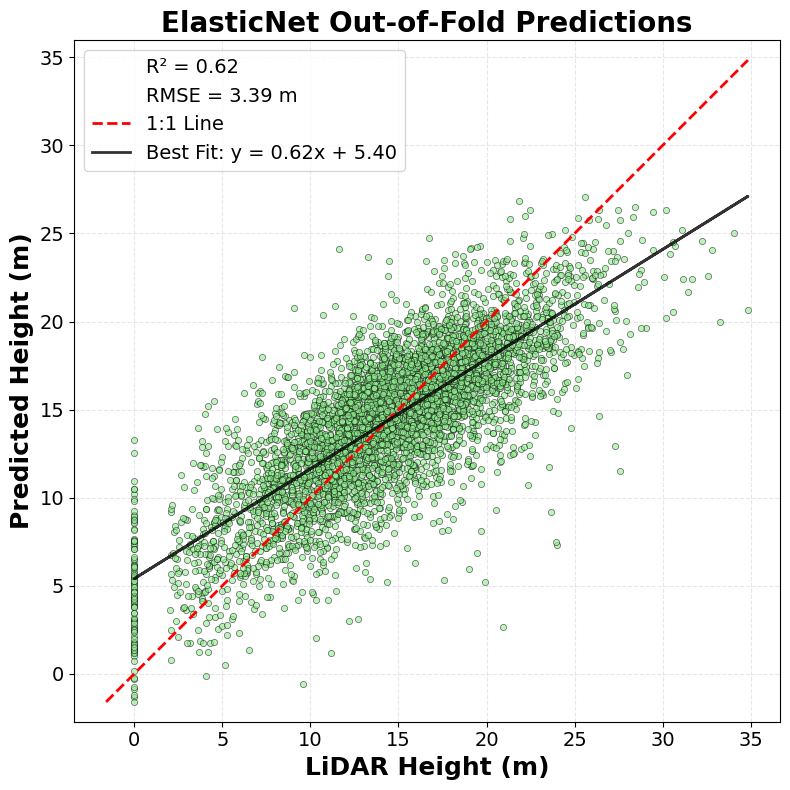

In [45]:
# Create regression plot
create_regression_plot(y, oof_predictions, oof_r2, oof_rmse, oof_mae, output_path)


In [46]:
# Train final model on all data
print("\nFitting the inference model w/ all data points...")
final_model = train_final_model(X, y, best_alpha, best_l1_ratio)
print("... fitting complete!")



Training final model on all data...
Final model training complete!


## Format the model coefficients for GEE

In the next script we will load the fitted model into Google Earth Engine to perform inference. This is pretty easy, as the model is simply a linear combination of 64 coefficients and their intercept. 

So, we will use the model transfer technique known as "copy-and-pasting". The logic below will print to console the JavaScript for an ee.Array of the coefficients and the intercept term. These are derived from our fitted model. 

In [52]:
# Print model coefficients
print_model_coefficients(final_model, wrap_every=8)


var coefficients = ee.Array([
  6.19459, -5.07152, -2.13330, -1.50041, 1.93469, -5.06554, -13.99216, 3.93983,
  1.88678, -1.25876, -2.51666, 7.24206, 4.96507, 1.22880, 0.69487, 3.84875,
  -3.53232, 5.80543, 1.39224, 6.15056, 11.89636, 2.45161, 2.07992, -1.82692,
  18.58459, 6.91228, -1.59726, 2.37284, -5.43373, -3.34663, 10.49117, -0.26164,
  0.92588, -7.53082, 2.54661, 1.50260, -9.45766, -0.00000, 2.00395, -14.97682,
  -8.94056, -1.33255, 11.96276, 14.57427, 3.01940, 2.50861, 5.47911, 1.56680,
  -7.19325, 12.25593, -4.82881, 3.04660, 6.19398, -2.77352, 10.43174, 18.10202,
  1.02136, 4.12324, -5.97319, 5.35299, 11.76329, -4.77091, 4.61425, -7.03878
]);

var intercept = 8.18619;
